In [2]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
import time

from sklearn.model_selection import train_test_split

import MeCab
from konlpy.tag import Okt

import sys
sys.path.append('/Users/anhyojun/WorkSpace/KDT2/MyModule')
from KDTModule import *

import torch.optim as optim
from torch.utils.data import DataLoader

In [3]:
# 시드 설정
torch.manual_seed(1)

In [4]:
text_list = []
label_list = []
PATH = '/Users/anhyojun/WorkSpace/KDT2/김소현 강사님/프로젝트/6번째 프로젝트/txt/'
txt_name = ['domestic2.txt', 'game2.txt', 'habby2.txt', 'overseas2.txt',
            'photo2.txt', 'restaurant2.txt', 'sports2.txt', 'vehicle2.txt']
for index, name in enumerate(txt_name):
    with open(PATH+name, 'r', encoding='utf-8') as f:
        text_list += f.readlines()
        label_list += [index] * 1000

In [5]:
text_list[:5], label_list[:5]

(['  산청펜션 맑은하늘펜션 자연의 평온한 분위기  산청펜션 맑은하늘펜션 자연의 평온한 분위기 안녕하세요 ෆ 일상에 지쳤다면, 산청펜션 맑은하늘펜션에서 힐링 어떠신가요? 경남 산청에 위치한 이 펜션은 일므 그대로 맑은 하늘과 깨끗한 자연이 자랑 인데요 특히 가족 단위나 친구들과 함께 가기에도 딱 좋은 힐링 공간이랍니다 맑은하늘펜션 산청펜션 맑은하늘펜션은 지리산의 맑은 공기와 자연을 만끽할 수 있는 곳이에요 봄에는 꽃구경, 여름에는 시원한 계곡, 가을에는 단풍, 겨울에는 조용한 휴식까지 사계절 내내 다양한 즐길 거리가 있어요 특히 주변에 다양한 산행 코스와 계곡이 있어서 자연 속에서 휴식과 힐링을 할 수 있죠 이곳에 오는 것만으로도 스트레스가 풀리고 힐링되는 느낌을 받을 수 있답니다 :) 가족 단위로 방문하면 아이들은 자연 속에서 마음껏 뛰놀 수 있고, 어른들은 조용하게 휴식을 취할 수 있고요 친구나 동호회 모임 등 단체루 방문해도 좋은데요 대형객실과 다양한 편의시설이 마련되어 있어서 많은 인원이 함께 머물기에도 편해요 자연과 함께하는 워크샵이나 힐링을 원하는 회사 단체 방문객도 만족할 만한 장소랍니다 객실은 편안하고 세련되게 꾸며져 있으며 자연을 배경으로 하여 평... \n',
  '  2024 대구 정원박람회 / 대구 금호강 하중도 금호꽃섬 코스모스 댑싸리 / 기본정보 일정 주차  대구에서 펼쳐지는 대한민국 정원 르네상스! 🌱✨ 2024 대구 정원박람회가 10월 11일부터 10월 15일까지 금호강 하중도에서 열립니다~! 시민, 학생, 가족 등 다양한 참여자들이 정성껏 가꾼 이색 정원 전시와🌼👩🎨 트렌드를 알아볼 수 있는 정원산업전,🌱 공연과 전시, 체험으로 알찬 정원 페스티벌까지!🎈 꽃과 자연의 아름다움이 가득한 2024 대구정원박람회에서 힐링의 시간을 가져보세요💕 2024 대구정원박람회 📍위치: 대구 북구 노곡동 665 (하중도) 📅일시: 10월 11일부터 15일까지 🚗주차: 노곡체육공원 주차장 이용 🚃대중교통: 북구3, 칠곡2 하차 후 노곡교 인도 이용

In [20]:
# 훈련, 검증, 테스트 분리
train_texts, test_texts, train_labels, test_labels = train_test_split(text_list, label_list, test_size=0.2,
                                                                      stratify=label_list, random_state=42)
train_texts, valid_texts, train_labels, valid_labels = train_test_split(train_texts, train_labels, test_size=0.2,
                                                                        stratify=train_labels, random_state=42)

print(f"[train] : {len(train_texts)}")
print(f"[valid] : {len(valid_texts)}")
print(f"[test] : {len(test_texts)}")

[train] : 5120
[valid] : 1280
[test] : 1600


In [21]:
# MeCab 토크나이저
def mecab_tokenizer(text):
    mecab = MeCab.Tagger('-r /opt/homebrew/etc/mecabrc -Owakati')
    return mecab.parse(text).split()

print(mecab_tokenizer(text_list[0]))

['산청펜션', '맑은하늘펜션', '자연의', '평온한', '분위기', '산청펜션', '맑은하늘펜션', '자연의', '평온한', '분위기', '안녕하세요', 'ෆ', '일상에', '지쳤다면', ',', '산청펜션', '맑은하늘펜션에서', '힐링', '어떠신가요', '?', '경남', '산청에', '위치한', '이', '펜션은', '일므', '그대로', '맑은', '하늘과', '깨끗한', '자연이', '자랑', '인데요', '특히', '가족', '단위나', '친구들과', '함께', '가기에도', '딱', '좋은', '힐링', '공간이랍니다', '맑은하늘펜션', '산청펜션', '맑은하늘펜션은', '지리산의', '맑은', '공기와', '자연을', '만끽할', '수', '있는', '곳이에요', '봄에는', '꽃구경', ',', '여름에는', '시원한', '계곡', ',', '가을에는', '단풍', ',', '겨울에는', '조용한', '휴식까지', '사계절', '내내', '다양한', '즐길', '거리가', '있어요', '특히', '주변에', '다양한', '산행', '코스와', '계곡이', '있어서', '자연', '속에서', '휴식과', '힐링을', '할', '수', '있죠', '이곳에', '오는', '것만으로도', '스트레스가', '풀리고', '힐링되는', '느낌을', '받을', '수', '있답니다', ':)', '가족', '단위로', '방문하면', '아이들은', '자연', '속에서', '마음껏', '뛰놀', '수', '있고', ',', '어른들은', '조용하게', '휴식을', '취할', '수', '있고요', '친구나', '동호회', '모임', '등', '단체루', '방문해도', '좋은데요', '대형객실과', '다양한', '편의시설이', '마련되어', '있어서', '많은', '인원이', '함께', '머물기에도', '편해요', '자연과', '함께하는', '워크샵이나', '힐링을', '원하는', '회사', '단체', '방문객도', '만족할', '만한', '장소랍니다', '

In [22]:
# Okt 토크나이저
print(Okt().morphs(text_list[0]))

['산청', '펜션', '맑은', '하늘', '펜션', '자연', '의', '평온한', '분위기', '산청', '펜션', '맑은', '하늘', '펜션', '자연', '의', '평온한', '분위기', '안녕하세요', 'ෆ', '일상', '에', '지쳤다면', ',', '산청', '펜션', '맑은', '하늘', '펜션', '에서', '힐링', '어떠신', '가요', '?', '경남', '산청', '에', '위치', '한', '이', '펜션', '은', '일므', '그대로', '맑은', '하늘', '과', '깨끗한', '자연', '이', '자랑', '인데요', '특히', '가족', '단위', '나', '친구', '들', '과', '함께', '가기', '에도', '딱', '좋은', '힐링', '공간', '이', '랍니', '다', '맑은', '하늘', '펜션', '산청', '펜션', '맑은', '하늘', '펜션', '은', '지리산', '의', '맑은', '공기', '와', '자연', '을', '만끽', '할', '수', '있는', '곳', '이에요', '봄', '에는', '꽃', '구경', ',', '여름', '에는', '시원한', '계곡', ',', '가을', '에는', '단풍', ',', '겨울', '에는', '조용한', '휴식', '까지', '사계절', '내내', '다양한', '즐길', '거리', '가', '있어요', '특히', '주변', '에', '다양한', '산행', '코스', '와', '계곡', '이', '있어서', '자연', '속', '에서', '휴식', '과', '힐링', '을', '할', '수', '있죠', '이', '곳', '에', '오는', '것', '만으로도', '스트레스', '가', '풀리고', '힐링', '되는', '느낌', '을', '받을', '수', '있답니다', ':)', '가족', '단위', '로', '방문', '하면', '아이', '들', '은', '자연', '속', '에서', '마음껏', '뛰놀', '수', '있고', ',', '

In [24]:
voca = build_voca(train_texts, stopwords='stopword.txt', tokenizer=Okt().morphs)
print(voca)

{'<PAD>': 0, '<UNK>': 1, '헨리': 2, '뷰': 3, 'UNICORN': 4, 'GAME': 5, 'PLUS': 6, '카드': 7, '슬리브': 8, 'TCG': 9, '서': 10, '플라이': 11, '시리즈': 12, '게이머': 13, '소중한': 14, '덱': 15, '지켜주는': 16, '프리미엄': 17, '매트': 18, '프로': 19, '텍터': 20, '타운': 21, '리파': 22, '경품': 23, '진행': 24, '하고': 25, '왔습니다': 26, '근데': 27, '대단히': 28, '운': 29, '잘': 30, '따라줘서': 31, '좋은': 32, '많이': 33, '건져': 34, '왔는데요': 35, '중': 36, '는': 37, '아니지만': 38, '정말': 39, '제품': 40, '획득': 41, '하여': 42, '께': 43, '소개': 44, '드리려': 45, '합니다': 46, '이렇게': 47, '두': 48, '팩': 49, '했는데요': 50, '좋아하는': 51, '빨간색': 52, '뜯어서': 53, '리뷰': 54, '해볼게요': 55, '다': 56, '채': 57, '로운': 58, '색상': 59, '자랑': 60, '하는': 61, '유니콘': 62, '게임': 63, '플러스': 64, '노란색': 65, '가져왔습니다': 66, '다양해서': 67, '선택': 68, '폭': 69, '넓네요': 70, '드릴': 71, '입니다': 72, '시뻘건': 73, '게': 74, '아주': 75, '매력': 76, '적': 77, '꽤': 78, '편이': 79, '에요': 80, '왠': 81, '진': 82, '모르겠는데': 83, '그렇게': 84, '좋더라구요': 85, '뜯어': 86, '보도록': 87, '하죠': 88, '저렇게': 89, '우당탕': 90, '나오는': 91, '그림': 92, '아닌데': 93, '진짜': 94, '멋있게': 9

In [26]:
train_tensor_token = make_tensor_token(train_texts, voca, stopwords='stopword.txt', tokenizer=Okt().morphs)
valid_tensor_token = make_tensor_token(valid_texts, voca, stopwords='stopword.txt', tokenizer=Okt().morphs)
# test_tensor_token = make_tensor_token(test_texts, voca, stopwords='stopword.txt', tokenizer=Okt().morphs)

train_tensor_token

[tensor([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
          16,  17,  18,  19,  20,   7,  21,  22,  23,   7,  21,  22,  24,  25,
          26,  27,  28,  29,  30,  31,  32,  23,  33,  34,  35,  36,   7,  37,
          38,  39,  32,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  41,
          50,  51,  52,  53,  54,  24,  55,   4,   5,   6,   7,   8,  56,  57,
          58,  59,  60,  61,  62,  63,  64,  18,   8,  37,  52,  65,  66,  59,
          67,  68,  69,  70,  44,  71,  40,  72,  73,  74,  75,  76,  77,  72,
          37,  52,  78,  51,  79,  80,  81,  82,  83,  52,  84,  85,  86,  87,
          88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
         102, 103, 104, 105, 106,   7, 107, 108, 109, 110, 111, 112, 113, 114,
         115,   8, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
         128, 129, 130, 131, 132,  74]),
 tensor([133, 134, 135, 136, 137, 138, 139, 136, 137, 140, 141, 142, 143, 144,
         13

In [27]:
token_length_list = [len(token) for token in train_tensor_token]
print(token_length_list)

[160, 180, 167, 166, 185, 179, 187, 169, 166, 171, 174, 175, 155, 183, 164, 170, 181, 171, 153, 198, 168, 171, 180, 187, 128, 167, 159, 169, 181, 156, 178, 159, 168, 189, 168, 187, 182, 151, 166, 179, 170, 182, 165, 199, 176, 165, 168, 169, 184, 172, 170, 159, 157, 169, 174, 160, 185, 196, 187, 160, 153, 186, 169, 171, 168, 179, 174, 162, 187, 173, 179, 162, 165, 169, 184, 184, 182, 75, 171, 165, 144, 172, 168, 163, 174, 167, 183, 170, 171, 173, 182, 169, 179, 159, 170, 167, 166, 171, 155, 186, 190, 183, 199, 169, 183, 167, 189, 144, 186, 166, 172, 179, 184, 145, 162, 149, 168, 160, 166, 175, 159, 188, 147, 172, 161, 153, 179, 160, 163, 173, 174, 184, 184, 166, 155, 189, 164, 173, 189, 179, 176, 166, 186, 177, 172, 171, 157, 184, 169, 176, 169, 163, 185, 174, 181, 177, 155, 172, 165, 186, 157, 157, 38, 165, 179, 184, 170, 177, 164, 178, 158, 156, 157, 172, 170, 179, 146, 190, 165, 179, 176, 193, 187, 167, 171, 181, 182, 165, 172, 188, 179, 162, 164, 168, 168, 158, 191, 171, 163, 189, 1

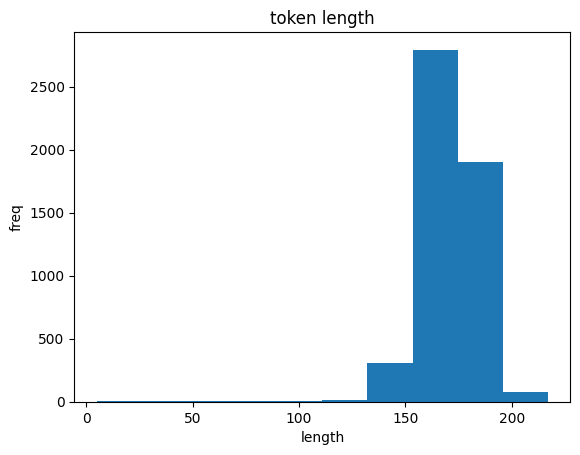

In [28]:
plt.hist(token_length_list)
plt.title('token length')
plt.xlabel('length')
plt.ylabel('freq')
plt.show()

In [29]:
max_length = 160
front = False

train_pad_token = pad_token_tensor(train_tensor_token, max_length=max_length, cut_front=front, padding_token=0)
valid_pad_token = pad_token_tensor(valid_tensor_token, max_length=max_length, cut_front=front, padding_token=0)
# est_pad_token = pad_token_tensor(test_tensor_token, max_length=max_length, cut_front=front, padding_token=0)

train_pad_token[0], train_pad_token.shape

(tensor([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
          16,  17,  18,  19,  20,   7,  21,  22,  23,   7,  21,  22,  24,  25,
          26,  27,  28,  29,  30,  31,  32,  23,  33,  34,  35,  36,   7,  37,
          38,  39,  32,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  41,
          50,  51,  52,  53,  54,  24,  55,   4,   5,   6,   7,   8,  56,  57,
          58,  59,  60,  61,  62,  63,  64,  18,   8,  37,  52,  65,  66,  59,
          67,  68,  69,  70,  44,  71,  40,  72,  73,  74,  75,  76,  77,  72,
          37,  52,  78,  51,  79,  80,  81,  82,  83,  52,  84,  85,  86,  87,
          88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
         102, 103, 104, 105, 106,   7, 107, 108, 109, 110, 111, 112, 113, 114,
         115,   8, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
         128, 129, 130, 131, 132,  74]),
 torch.Size([5120, 160]))

In [30]:
train_labels2D = [[label] for label in train_labels]
valid_labels2D = [[label] for label in valid_labels]
# test_labels2D = [[label] for label in test_labels]]
train_labels2D[:5]

[[1], [3], [2], [6], [4]]

In [31]:
trainDS = TextDataset(train_pad_token, train_labels2D)
validDS = TextDataset(valid_pad_token, valid_labels2D)

In [33]:
batch_size = 8

trainDL = DataLoader(trainDS, batch_size = batch_size)
validDL = DataLoader(validDS, batch_size = batch_size)

n_vocab = len(voca)
hidden_dim = 64
embedding_dim = 128
n_layers = 3
dropout = 0.5

model = SentenceClassifier(n_vocab, hidden_dim, embedding_dim, n_layers, output_size=8,
                           dropout=dropout, bidirectional=True, model_type='lstm')

adam = optim.Adam(model.parameters(), lr=0.001)
rmsprop = optim.RMSprop(model.parameters(), lr=0.001)

EPOCH = 100
MODEL_PATH = '/Users/anhyojun/WorkSpace/KDT2/김소현 강사님/TORCH_NLP/숙제/model_1009'

result = training(trainDL, validDL, model, model_type='multiclass', optimizer=adam,
                  epoch=EPOCH, endurance_cnt=10, view_epoch=1, num_classes=8, SAVE_PATH=MODEL_PATH)

[EPOCH] : 1에서 모델 저장 완료.
[Loss : 1/100] Train : 2.0557, Test : 1.9819
[Score  : 1/100] Train : 0.1621, Test : 0.2281
[EPOCH] : 2에서 모델 저장 완료.
[Loss : 2/100] Train : 1.7560, Test : 1.6435
[Score  : 2/100] Train : 0.3074, Test : 0.3500
[EPOCH] : 3에서 모델 저장 완료.
[Loss : 3/100] Train : 1.3519, Test : 1.5543
[Score  : 3/100] Train : 0.4600, Test : 0.3914
[Loss : 4/100] Train : 1.1585, Test : 1.5784
[Score  : 4/100] Train : 0.5488, Test : 0.4320
[EPOCH] : 5에서 모델 저장 완료.
[Loss : 5/100] Train : 0.8653, Test : 1.4130
[Score  : 5/100] Train : 0.6736, Test : 0.5031
[Loss : 6/100] Train : 0.7593, Test : 1.5768
[Score  : 6/100] Train : 0.7217, Test : 0.5062
[Loss : 7/100] Train : 0.4776, Test : 1.6257
[Score  : 7/100] Train : 0.8391, Test : 0.5281
[Loss : 8/100] Train : 0.3089, Test : 1.7937
[Score  : 8/100] Train : 0.9012, Test : 0.5352
[Loss : 9/100] Train : 0.2574, Test : 1.9325
[Score  : 9/100] Train : 0.9215, Test : 0.5312
[Loss : 10/100] Train : 0.3163, Test : 1.8344
[Score  : 10/100] Train : 0.90

In [ ]:
df = pd.DataFrame()